In [190]:
import math
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import lea
import ipywidgets
from fractions import Fraction

# Elementary Hypothesis Testing

We observe some data and imagine one or more hypotheses that underlie our observations. How do we measure our confidence in a particular hypothesis? And how do we compare our confidence between multiple competing hypotheses?

Jaynes introduces this concept in Chapter Four with an example of quality assurance in a "widget" factory. In this chapter, Jaynes distinguishes between binary hypothesis testing (measuring our confidence between only two possibilities) and multiple hypothesis testing (numbering more than two, and possibly infinite). Jaynes makes the point that the logical independence of observing data under a binary hypothesis context is not in preserved in the multiple hypothesis case; this is proven by exercise 4.1 on page 97.

The primary purpose of this notebook is to clarify this concept, in other words, to illustrate "*the cogent information that would be lost*" as Jaynes writes on p.104, if the same method for binary hypothesis comparison was extended to the multiple hypothesis case. 


### Problem Setup (Background Information $X$)

The example on p.93 goes, suppose we have eleven machines each producing "widgets" --- that is, a product that we can test for good or bad craftsmanship. We suppose that ten out of the eleven machines are good manufacturers: for every **six** widgets they create, only one is defective. The eleventh machine is a bad manufacturer, and for every **three** widgets it creates, one is defective.

![title](./factory_widgets.png)

Each machine stores its widget production into an exclusive, unlabelled box containing $N$ widgets. Now suppose we are given one of these unlabelled boxes. We do not know what machine it came from, so we start testing the constituent widgets one by one for good craftsmanship. What is our confidence that our box came from one of the ten good machines versus the eleventh bad machine?

Our hypothesis declares which machine we believe the box to originate from. This also determines the sampling probability $\theta$ that we expect is generating our observations. More concretely, given a hypothesis which determines $\theta$, we model the observation of a single widget from our unlabelled box as a bernoulli random variable $D_i | \theta \sim Bernoulli(\theta)$

And, assuming that the total number of widgets in our box is massively larger than our sample size $N >> k$, the probability distribution for the entire sequence our observations is represented by a Binomial random variable 

\begin{equation}
\begin{split}
D | \theta &\sim Binomial(k, N, \theta) \\
&= D_1|\theta \ + \ ... \ + \ D_N|\theta \\
&= {N \choose k} \theta^N (1 - \theta)^{N - n}
\end{split}
\end{equation}

Jaynes measures our confidence in a particular hypothesis $H$ (which determines the sampling probability $\theta_H$) by calculating its "evidence" in light of the data. "Evidence" is defined by adding the log-likelihood of generating $D$ under the belief $H$ to our pre-existing prior evidence of hypothesis $H$. This is written concretely on pages 90-92:

\begin{equation}
\begin{split}
e(H|X) &= 10 log_{10} \frac{P(H|X)}{P( \overline H | X)} \\
\text{and,} \\
e(H|DX) &= e(H|X) + 10 log_{10} \left[ \frac{P(D|H X)}{P(D | \overline H X)} \right] \\
&= e(H|X) + 10 \sum_i log_{10} \left[ \frac{P(D_i|HX)}{P(D_i| \overline H X)} \right] \\
&= e(H|X) + N \cdot 10 log_{10} \left( \frac{\theta_H}{\theta_{\overline H}} \right) + (N - n) \cdot 10 log_{10} \left( \frac{1 - \theta_H}{1 - \theta_{\overline H}} \right)
\end{split}
\end{equation}

Where the binomial $N \choose k$ coefficients cancel out and we are left with the summed log-probability ratios $log_{10} \left( \frac{\theta_H}{\theta_{\overline H}} \right)$ and $log_{10} \left( \frac{1 - \theta_H}{1 - \theta_{\overline H}} \right)$

## Binary Hypothesis Testing

Those are all of the definitions we need so far to measure the evidence between exactly two competing hypotheses: is the unlabelled box we are currently observing from machine $A$, or from machine $B_i$?

From our background information $X$ and the principle of indifference derived in Chapter two, we can assign prior probabilities:

\begin{equation}
P(H=A|X) = P(A|X) = 1/11 \\
P(H=B|X) = P (B|X) = 10/11
\end{equation}

and sampling probabilities of observing a good widget at trial $i$:
\begin{equation}
P(D_i|A X) = 2/3 \\
P(D_i|B X) = 5/6
\end{equation}

To illustrate the evidence we generate in this model in light of particular data, we encode our inference rules using Lea, [a python library](https://bitbucket.org/piedenis/lea/) for intuitive probabilistic programming.

We represent $H$ and $D_i$ with random variables (whose parameters can be changed to visualize a different graph):

In [231]:
H = lea.pmf({'A': Fraction(1, 11), 'B': Fraction(10, 11)})
D_i = H.switch({
    'A': lea.bernoulli(Fraction(2, 3)),
    'B': lea.bernoulli(Fraction(5, 6))
})
D = lambda N: H.switch({
    'A': lea.binom(N, lea.P(D_i.given(H == 'A') == 1)),
    'B': lea.binom(N, lea.P(D_i.given(H == 'B') == 1))
})
lea.lr(

StopIteration: 

And we program the definition for evidence between two competing hypotheses from equation (4.13): 

In [188]:
def evidence_of(X, x):
    return 10 * (math.log(lea.P(X == x), 10) - math.log(lea.P(X != x), 10))

def additive_likelihood_of(h, data):
    N = data.size
    n = data[data == 1].size
    if N == 0: # times() requires strictly postive integer
        return 0
    ratio = lea.P(D_i.given(H == h).times(N) == n) / lea.P(D_i.given(H != h).times(N) == n)
    return 10 * math.log(ratio, 10)

lea_additive_likelihood = 3

def evidence_posterior(likelihood_func, h, data):
    likelihood = likelihood_func(h, data)
    return evidence_of(H, h) + likelihood

def graph_evidence(h, data):
    return np.array([evidence_posterior(additive_likelihood_of, h, data[:i]) for i in range(data.size)])

Now we have all the machinery in place to illustrate evidence in the binary hypothesis case.

For example, a sequence of ten bad widgets in a row shows the erosion of hypothesis $B$ (the good machine) in favour of hypothesis $A$ (the bad one):

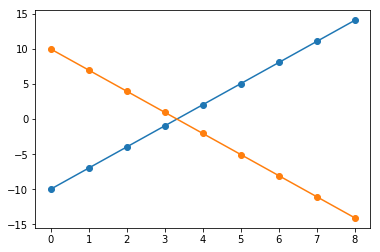

In [197]:
# Observed sequence of bad widgets
data = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])

for h in ['A', 'B']:
    plt.plot(range(data.size), graph_evidence(h, data), '-o')

We see that these hypotheses operate (on the log-scale) with opposite linear slope, proportional to each independent observation in our sequence of observations. 
This is explained on page 95:

\begin{equation}
e(A|DX) ~= e(A|X) + 4k - N \\
e(B|DX) ~= e(B|X) - 4k + N
\end{equation}

For another example, if we observe two good widgets in the middle of the sequence, our confidence in the respective hypotheses will change by a slope corresponding to the log-likelihood of observing these two good widgets:

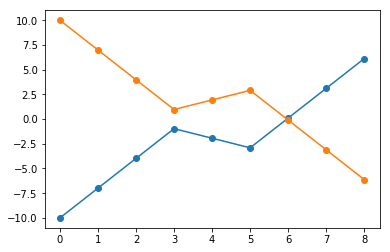

In [200]:
# Observed sequence widgets
data = np.array([0, 0, 0, 1, 1, 0, 0, 0, 0])

for h in ['A', 'B']:
    plt.plot(range(data.size), graph_evidence(h, data), '-o')

## Multiple Hypothesis Testing

Now we are equipped to illustrate Jaynes' point on the "*cogent information that would be lost*" if we extended the same method for binary hypothesis testing to multiple hypothesis testing.

Say we have a third hypothesis C, that the box we are observing is coming from an even worse machine which creates **nintey-nine** bad widgets out of a hundred. What modification do we make to our calculations for multiple hypothesis testing, and what difference does it make?

As proven in exercise 4.1 on page 97, the fundamental difference between binary and multiple hypotheses testing is that the data log-likelihood term is non-additive:

\begin{equation}
\begin{split}
log_{10} \left( \frac{P(D_1, ..., D_N| H_i X)}{P(D_1, ..., D_N| \overline H_i X)} \right) &\neq \sum_j log_{10} \left( \frac{P(D_j | H_i X}{P(D_j | \overline H_i X)} \right)
\end{split}
\end{equation}

Instead, we must use Bayes' theorem for $P(D_1, ..., D_N|HX)$ as in equation (4.39) on page 101:

\begin{equation} P(D | \overline H_i X) = \frac{ \sum_i P(D |H_i X)P(H_i|X)}{\sum_i P(H_i|X)} \end{equation} 

Returning to our problem setup, random variable $D$ is binomially distributed, meaning it refers to the success of at least $k$ out of $N$ independent bernoulli random variables. The non-additivity of our data-likelihood in this context means we have to re-calculate our evidence $(e|H_iX)$ for the multiple-hypothesis case. 

In [201]:
H = lea.pmf({'A': 1/11 * (1 - pow(10, -6)), 'B': 10/11 * (1 - pow(10, -6)), 'C': pow(10, -6)})
D_i = H.switch({
    'A': lea.bernoulli(2/3),
    'B': lea.bernoulli(5/6),
    'C': lea.bernoulli(1/100)
})

Help on Alea in module lea.alea object:

class Alea(lea.lea.Lea)
 |  Alea is a Lea subclass, which instance is defined by explicit probability distribution data.
 |  An Alea instance is defined by given value-probability pairs, that is an explicit probability
 |  mass function (pmf). The probabilities can be expressed as any object with arithmetic semantic.
 |  The main candidates are float, fraction or symbolic expressions.
 |  
 |  Method resolution order:
 |      Alea
 |      lea.lea.Lea
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  P(self)
 |      returns the probability that self is True;
 |      the probability is expressed in the probability type used in self,
 |      possibly downcasted for convenience (Fraction -> ProbFraction,
 |      Decimal -> ProbDecimal);
 |      raises an exception if some value in the distribution is not boolean
 |      (note that this is NOT the case with self.p(True))
 |      WARNING: this method is called without parentheses
 |  
 |

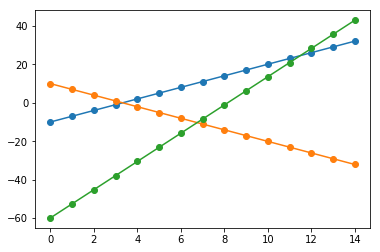

In [209]:
# Observed sequence of bad widgets
data = np.array([0] * 15)

for h in ['A', 'B', 'C']:
    plt.plot(range(data.size), graph_evidence(h, data), '-o')
    
help(H)

In [128]:

def binomial(x, n, p):
    coefficient = math.factorial(n) / (math.factorial(x) * math.factorial(n - x))
    return coefficient * pow(p, x) * (1 - p, n - x)

def ev_a_new(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 1/11 * (1 - pow(10, -6))
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    
    ev_post_numerator_good = pow(2/3, num_good)
    ev_post_denominator_good = pow(5/6, num_good) + (11/10 * pow(10, -6) * pow(1/100, num_good))
    
    ev_post_numerator_bad = pow(1/3, num_bad)
    ev_post_denominator_bad = pow(1/6, num_bad) + (11/10 * pow(10, -6) * pow(99/100, num_bad))
    
    ev_posterior = 10 * (math.log(ev_post_numerator_good / ev_post_denominator_good, 10) + 
                         math.log(ev_post_numerator_bad / ev_post_denominator_bad, 10))
    return ev_prior + ev_posterior


def ev_b_new(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 10/11 * (1 - pow(10, -6))
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    
    ev_post_numerator_good = pow(5/6, num_good)
    ev_post_denominator_good = ((1 - pow(10, -6)) * pow(2/3, num_good)) + (11 * pow(10, -6) * pow(1/100, num_good))
    
    ev_post_numerator_bad = pow(1/6, num_bad)
    ev_post_denominator_bad = ((1 - pow(10, -6)) * pow(1/3, num_bad)) + (11 * pow(10, -6) * pow(99/100, num_bad))

    ev_posterior = 10 * (math.log(ev_post_numerator_good / ev_post_denominator_good, 10) + 
                         math.log(ev_post_numerator_bad / ev_post_denominator_bad, 10))
    
    return ev_prior + ev_posterior


def ev_c_new(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = pow(10, -6)
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    
    ev_post_numerator_good = pow(1/100, num_good)
    ev_post_denominator_good = (1/11 * (1 - pow(10, -6)) * pow(2/3, num_good)) + (10/11 * (1 - pow(10, -6)) * pow(5/6, num_good))
    
    ev_post_numerator_bad = pow(99/100, num_bad)
    ev_post_denominator_bad = (1/11 * (1 - pow(10, -6)) * pow(1/3, num_bad)) + (10/11 * (1 - pow(10, -6)) * pow(1/6, num_bad))

    ev_data_likelihood = 10 * (math.log(ev_post_numerator_good / ev_post_denominator_good, 10) + 
                         math.log(ev_post_numerator_bad / ev_post_denominator_bad, 10))
    return ev_prior + ev_data_likelihood


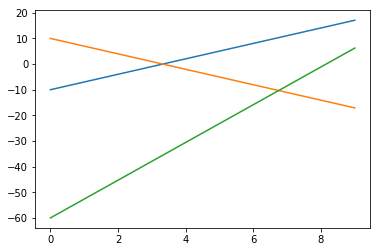

\begin{equation} P(D|AX) = {N \choose n} (1/3)^n (2/3)^{N-n} \end{equation}
\begin{equation} P(D|BX) = {N \choose n} (1/6)^n (5/6)^{N-n} \end{equation}

In [ ]:
def evidence(X, x):
    return 10 * (math.log(lea.P(X == x), 10) - math.log(lea.P(X != x), 10))

def widget_likelihood(h, data):
    N = data.size
    n = data[data == 1].size
    ratio = lea.P(widget.given(hypothesis == h).times(N) == n) / lea.P(widget.given(hypothesis != h).times(N) == n)
    return 10 * math.log(ratio, 10)

def evidence_posterior(h, data):
    return evidence(hypothesis, h) + widget_likelihood(h, data)

In [134]:
# Probabilities of seeing # GOOD widgets in N sequential tosses
print(D_i.given(H == 'A').times(1))

print(D_i.given(H != 'A').times(1))

0 : 0.33333333333333337
1 : 0.6666666666666666
0 : 0.16666757233324273
1 : 0.8333324276667573


In [ ]:
def binomial(x, n, p):
    coefficient = math.factorial(n) / (math.factorial(x) * math.factorial(n - x))
    return coefficient * pow(p, x) * (1 - p, n - x)

def ev_a(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 1/11
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    ev_posterior = 10 * (math.log(pow(2/3, num_good) / pow(5/6, num_good), 10) + math.log(pow(1/3, num_bad) / pow(1/6, num_bad), 10))
    return ev_prior + ev_posterior
    
def ev_b(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 10/11
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    ev_posterior = 10 * (math.log(pow(5/6, num_good) / pow(2/3, num_good), 10) + math.log(pow(1/6, num_bad) / pow(1/3, num_bad), 10))
    return ev_prior + ev_posterior

In [ ]:
data = np.array([0] * 10)
evidence = np.array([ev_a(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

evidence = np.array([ev_b(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

In [ ]:
data_size = 10
heatmap = []
for num_good in range(data_size):
    lst = []
    for num_bad in range(data_size):
        data = np.array([0] * num_bad + [1] * num_good)
        heat = ev_b(data) - ev_a(data)
        lst.append(heat)
    heatmap.append(lst)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.array(heatmap))
ax.invert_yaxis()
plt.show()

In [52]:
def binomial(x, n, p):
    coefficient = math.factorial(n) / (math.factorial(x) * math.factorial(n - x))
    return coefficient * pow(p, x) * (1 - p, n - x)

def ev_a_new(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 1/11 * (1 - pow(10, -6))
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    
    ev_post_numerator_good = pow(2/3, num_good)
    ev_post_denominator_good = pow(5/6, num_good) + (11/10 * pow(10, -6) * pow(1/100, num_good))
    
    ev_post_numerator_bad = pow(1/3, num_bad)
    ev_post_denominator_bad = pow(1/6, num_bad) + (11/10 * pow(10, -6) * pow(99/100, num_bad))
    
    ev_posterior = 10 * (math.log(ev_post_numerator_good / ev_post_denominator_good, 10) + 
                         math.log(ev_post_numerator_bad / ev_post_denominator_bad, 10))
    return ev_prior + ev_posterior


def ev_b_new(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 10/11 * (1 - pow(10, -6))
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    
    ev_post_numerator_good = pow(5/6, num_good)
    ev_post_denominator_good = ((1 - pow(10, -6)) * pow(2/3, num_good)) + (11 * pow(10, -6) * pow(1/100, num_good))
    
    ev_post_numerator_bad = pow(1/6, num_bad)
    ev_post_denominator_bad = ((1 - pow(10, -6)) * pow(1/3, num_bad)) + (11 * pow(10, -6) * pow(99/100, num_bad))

    ev_posterior = 10 * (math.log(ev_post_numerator_good / ev_post_denominator_good, 10) + 
                         math.log(ev_post_numerator_bad / ev_post_denominator_bad, 10))
    
    return ev_prior + ev_posterior


def ev_c_new(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = pow(10, -6)
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    
    ev_post_numerator_good = pow(1/100, num_good)
    ev_post_denominator_good = (1/11 * (1 - pow(10, -6)) * pow(2/3, num_good)) + (10/11 * (1 - pow(10, -6)) * pow(5/6, num_good))
    
    ev_post_numerator_bad = pow(99/100, num_bad)
    ev_post_denominator_bad = (1/11 * (1 - pow(10, -6)) * pow(1/3, num_bad)) + (10/11 * (1 - pow(10, -6)) * pow(1/6, num_bad))

    ev_data_likelihood = 10 * (math.log(ev_post_numerator_good / ev_post_denominator_good, 10) + 
                         math.log(ev_post_numerator_bad / ev_post_denominator_bad, 10))
    return ev_prior + ev_data_likelihood


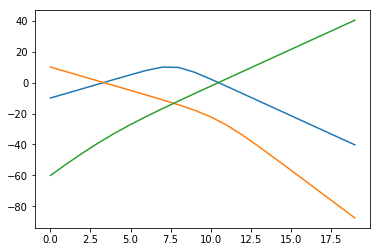

In [53]:
data = np.array([0] * 20)
evidence = np.array([ev_a_new(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

evidence = np.array([ev_b_new(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

evidence = np.array([ev_c_new(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

In [ ]:
def D(H):
    if H == 0:
        return 1/3
    else:
        return 1/6

with pm.Model() as model:
    H_prior = pm.Categorical('H_prior', [1/11, 10/11])
    D_given_H = pm.Deterministic('D_given_H', pm.math.switch(np.array(H_prior == 0), 1/3, 1/6))

In [ ]:
model.free_RVs

In [ ]:
import lea

In [ ]:
hypothesis = lea.pmf({'A': 1/11, 'B': 10/11})
widget = hypothesis.switch({
    'A': lea.event(2/3),
    'B': lea.event(5/6)
})
data = (False, False, False)

In [ ]:
widget_given_B = widget.given(hypothesis=='B')
widgets = lea.joint(*([widget_given_B.new() for i in range(3)]))
lea.P(widgets == data)

In [ ]:
hypothesis = lea.pmf({'A': 1/11 * (1 - pow(10, -6)), 'B': 10/11 * (1 - pow(10, -6)), 'C': pow(10, -6)})
widget = hypothesis.switch({
    'A': lea.bernoulli(2/3),
    'B': lea.bernoulli(5/6),
    'C': lea.bernoulli(1/100)
})

widget_given_B = widget.given(hypothesis=='B')

a_widgets = widget.given(hypothesis=='A').times(3)
b_widgets = widget.given(hypothesis=='B').times(3)

print(1/3 * 1/11 + 1/6 * 10/11)
widget.given(hypothesis!='C')

In [ ]:
def A(x):
    return x

In [ ]:
ipywidgets.interact(A, x=10)

In [ ]:
def D(N):
    if N == 0:
        return 0 # lea.Lea.times() requires strictly positive integer
    ratio = H.switch({
        'A': lea.binom(N, lea.P(D_i.given(H == 'A') == 1)) / lea.binom(N, lea.P(D_i.given(H != 'A') == 1))
    })
    print(D_i.given(H != 'A'))
    return 10 * math.log(ratio, 10)

D(2).given(H == 'A')

In [199]:
A_prior = Fraction(1/11)
B_prior = Fraction(10/11)

A_prior = ipywidgets.FloatSlider(value=Fraction(1/11), min=0, max=1, step=Fraction(1/11), description="P(A|X)")
B_prior = ipywidgets.FloatSlider(value=Fraction(10/11), min=0, max=1, step=Fraction(1/11), description="P(B|X)")

display(A_prior)
display(B_prior)

A_sample_prob = ipywidgets.BoundedFloatText(value=Fraction(2/3), min=0, max=1, step=Fraction(1/6), description="P(D|AX)")
B_sample_prob = ipywidgets.BoundedFloatText(value=Fraction(5/6), min=0, max=1, step=Fraction(1/6), description="P(D|BX)")

display(A_sample_prob)
display(B_sample_prob)

10 * math.log(1/2, 10)

FloatSlider(value=0.09090909090909091, description='P(A|X)', max=1.0, step=0.09090909090909091)

FloatSlider(value=0.9090909090909091, description='P(B|X)', max=1.0, step=0.09090909090909091)

BoundedFloatText(value=0.6666666666666666, description='P(D|AX)', max=1.0, step=0.16666666666666666)

BoundedFloatText(value=0.8333333333333334, description='P(D|BX)', max=1.0, step=0.16666666666666666)

-3.0102999566398116

In our current problem statement, a single widget observation is a bernoulli random variable $D_i \sim Bernoulli(p)$, and the total sequence of our observations including $k$ good widgets is a Binomial random variable $D \sim Binomial(k, N, p) = D_1 + ... + D_N$